In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, learning_curve

# Functions

### Thresholding

In [ ]:
def advanced_otsu_thresholding(image):
    # Ensure the image is in grayscale
    if len(image.shape) != 2:
        raise ValueError("The image should be in grayscale")

    # Apply Gaussian blur to the image
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Calculate histogram and normalize it
    hist = cv2.calcHist([blurred], [0], None, [256], [0, 256]).flatten()
    hist = hist / hist.sum()

    # Calculate probability of each intensity level
    total = blurred.size
    prob = hist / total

    # Valley Deepness Calculation
    valley_deepness = np.zeros_like(hist)
    for t in range(1, len(hist)-1):
        left_peak = max(hist[:t])
        right_peak = max(hist[t+1:])
        valley_deepness[t] = max(0, left_peak - hist[t]) + max(0, right_peak - hist[t]) / 2

    # Weight Calculation
    weights = (1 - prob) + valley_deepness

    # Find optimal threshold by maximizing the weighted between-class variance
    max_var = -1
    best_threshold = 0
    for t in range(1, len(hist)):
        w0 = np.sum(prob[:t])
        w1 = np.sum(prob[t:])
        if w0 == 0 or w1 == 0:
            continue
        mu0 = np.sum(np.arange(t) * prob[:t]) / w0
        mu1 = np.sum(np.arange(t, len(hist)) * prob[t:]) / w1
        var_between = w0 * w1 * (mu0 - mu1) ** 2 * weights[t]
        if var_between > max_var:
            max_var = var_between
            best_threshold = t

    # Apply the threshold to get binary mask
    _, binary_mask = cv2.threshold(blurred, best_threshold, 255, cv2.THRESH_BINARY)

    return binary_mask

### HSV

In [ ]:
def create_hsv_fire_mask(hsv_image):
    lower_fire = np.array([10, 100, 100])    # Adjust these values as needed
    upper_fire = np.array([35, 255, 255])    # Adjust these values as needed
    return cv2.inRange(hsv_image, lower_fire, upper_fire)

### Modelling

In [ ]:
def color_moments(image, mask):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    masked_hsv = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)
    moments = []
    for i in range(3):  # H, S, V channels
        channel = masked_hsv[:, :, i]
        channel_nonzero = channel[channel > 0]
        if channel_nonzero.size == 0:
            # No valid pixels, set to zero
            moments.extend([0.0, 0.0, 0.0])
        else:
            mean = np.nan_to_num(np.mean(channel_nonzero))
            std_dev = np.nan_to_num(np.std(channel_nonzero))
            skewness_value = np.mean((channel_nonzero - mean) ** 3)
            skewness = np.nan_to_num(skewness_value ** (1/3)) if skewness_value != 0 else 0.0
            moments.extend([mean, std_dev, skewness])
    return np.array(moments)

In [ ]:
def entropy_feature(gray_image, mask):
    masked_gray = cv2.bitwise_and(gray_image, gray_image, mask=mask)
    if np.count_nonzero(masked_gray) == 0:
        return np.array([0.0])
    else:
        entropy_value = shannon_entropy(masked_gray[masked_gray > 0])
        return np.array([np.nan_to_num(entropy_value)])

In [ ]:
def extract_combined_features(image, binary_mask, hsv_mask):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    color_moments_features = color_moments(image, hsv_mask)
    entropy_value = entropy_feature(gray_image, binary_mask)
    features = np.concatenate([color_moments_features, entropy_value])
    features = np.nan_to_num(features)  # Replace any NaNs left with zero
    return features

### Utility

In [ ]:
def load_images(image_path, image_files):
    images = []
    for image_file in image_files:
        image_path_full = os.path.join(image_path, image_file)
        image = cv2.imread(image_path_full)
        if image is None:
            print(f"Warning: Could not read image {image_path_full}")
            continue

        images.append(image)
    return images

In [ ]:
def show_images(images, titles, num_images, images_per_row):
    # Calculate number of rows needed to display all images
    rows = math.ceil(num_images / images_per_row)

    # Create a figure with the appropriate size
    plt.figure(figsize=(images_per_row * 3, rows * 3))  # Adjust size based on the number of rows and columns

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def apply_mask(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

In [ ]:
def convert_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Setting Up

### Colab

In [ ]:
# Path to your dataset folders (colab)
fire_path = '/content/drive/MyDrive/DATASET PCD/Training/fire_images'
non_fire_path = '/content/drive/MyDrive/DATASET PCD/Training/non_fire_images'

fire_files = os.listdir(fire_path)
non_fire_files = os.listdir(non_fire_path)

### Local

In [ ]:
# Path to your dataset folders
fire_path = 'C:/Users/user/VSCode/DATA/UGM/PCD/Training/fire_images'
non_fire_path = 'C:/Users/user/VSCode/DATA/UGM/PCD/Training/non_fire_images'

fire_files = os.listdir(fire_path)
non_fire_files = os.listdir(non_fire_path)

In [ ]:
# Load the images
fire = load_images(fire_path, fire_files)
non_fire = load_images(non_fire_path, non_fire_files)

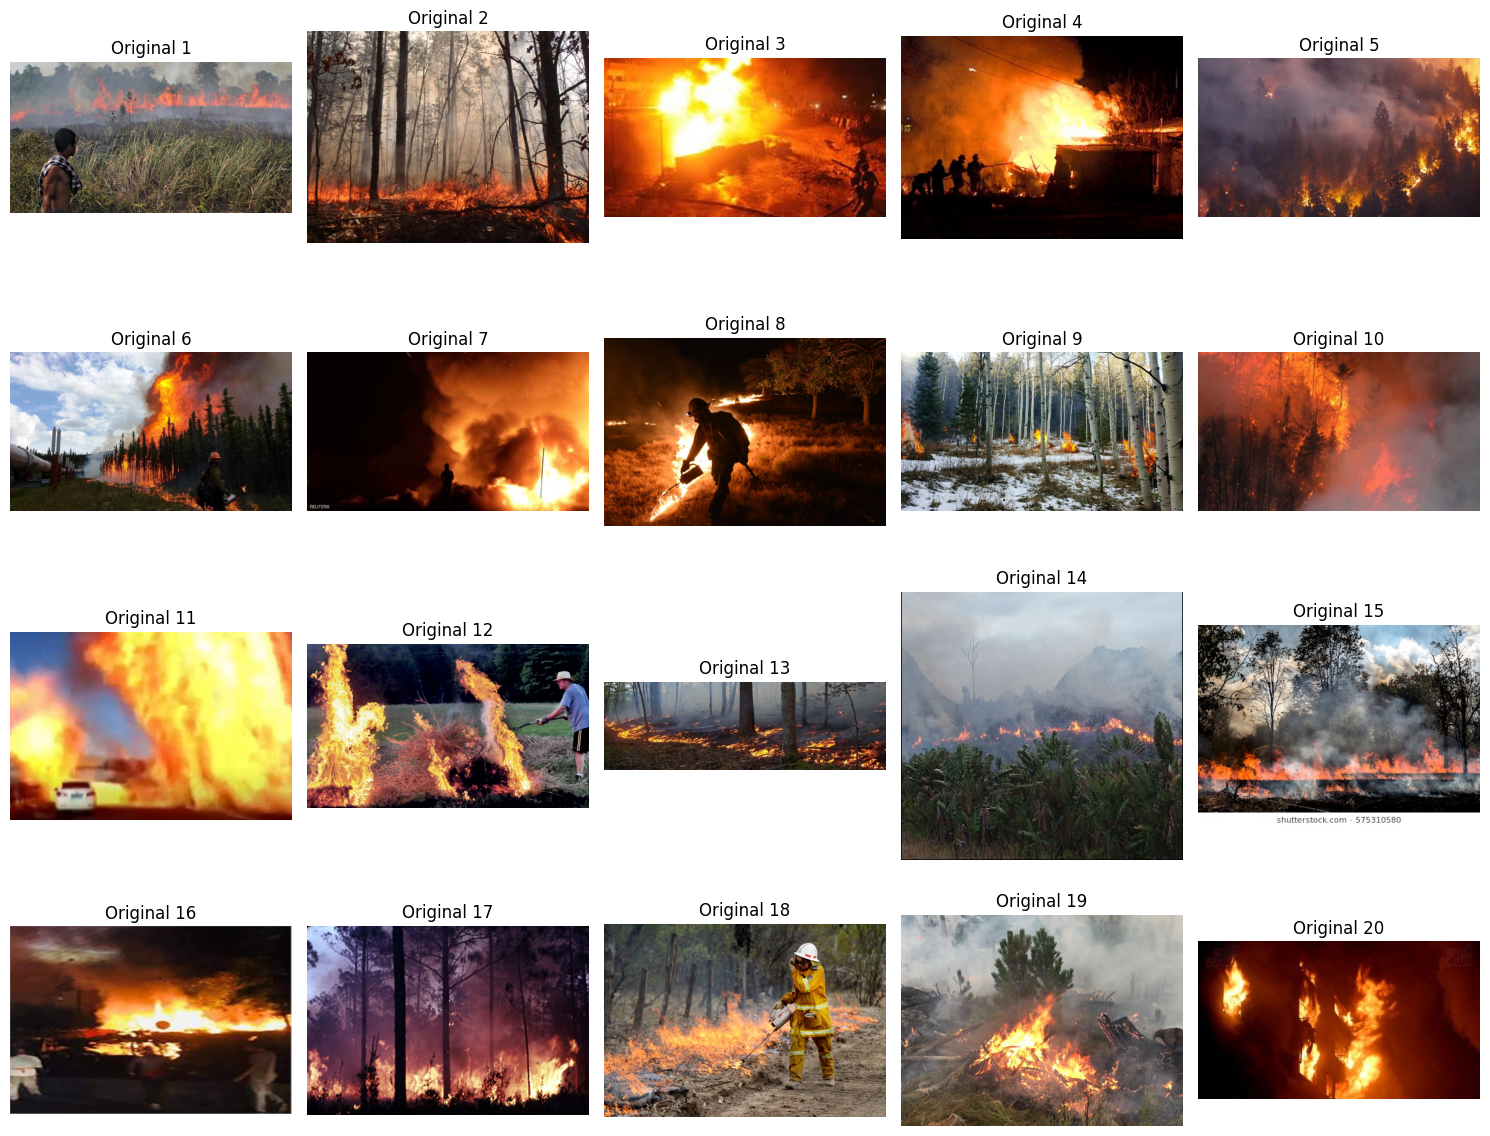

In [ ]:
# Show the first 20 of the original images:
show_images(fire[:20], [f"Original {i+1}" for i in range(20)], 20, 5)

# Thresholding

In [ ]:
# Creating the mask using advanced otsu and showing it
fire_binary_masks = [advanced_otsu_thresholding(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) for image in fire]

show_images(fire_binary_masks[:20], [f"Binary Mask {i+1}" for i in range(20)], 20, 5)

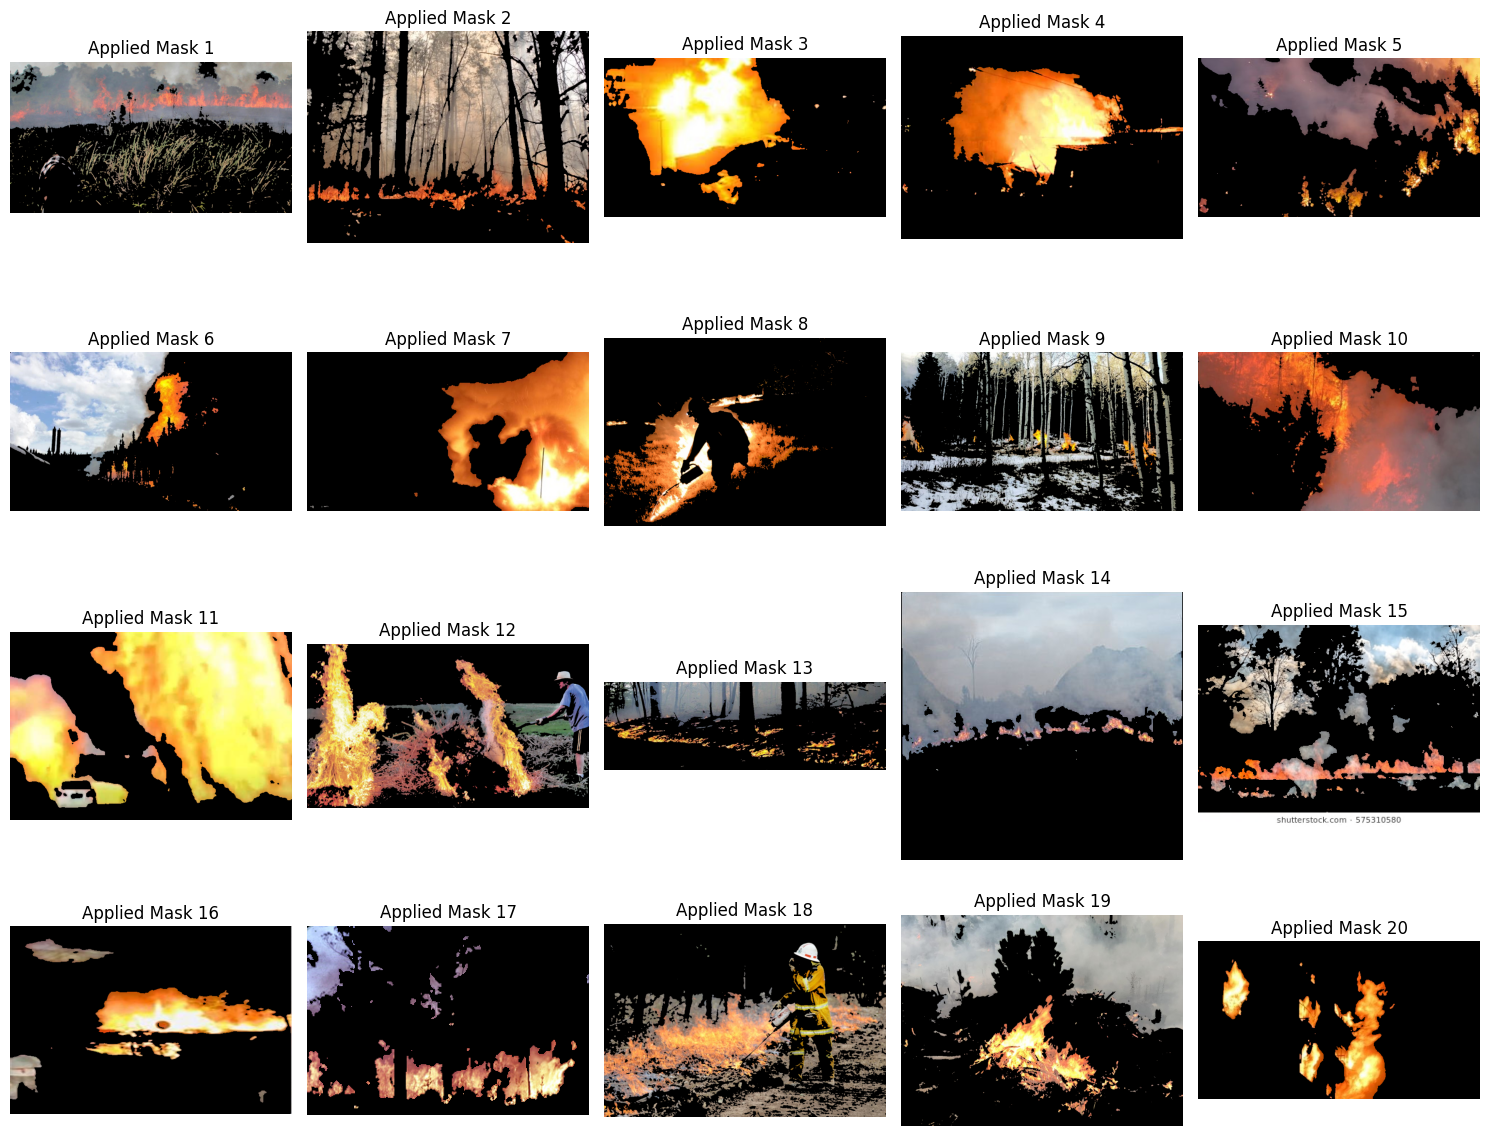

In [ ]:
# Applying the mask and showing the result
fire_masked = [apply_mask(image, binary_mask) for image, binary_mask in zip(fire, fire_binary_masks)]

show_images(fire_masked[:20], [f"Applied Mask {i+1}" for i in range(20)], 20, 5)


### Apply to non fire images

In [ ]:
# Applying to non_fire images
nonfire_masks = [advanced_otsu_thresholding(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) for image in non_fire]
nonfire_masked = [apply_mask(image, nonfire_mask) for image, nonfire_mask in zip(non_fire, nonfire_masks)]


# Convert

In [ ]:
# Creating the mask using the hsv method and pre defined boundary and showing it
fire_hsv_masks = [create_hsv_fire_mask(convert_to_hsv(masked_image)) for masked_image in fire_masked]

show_images(fire_hsv_masks[:20], [f"HSV Mask {i+1}" for i in range(20)], 20, 5)

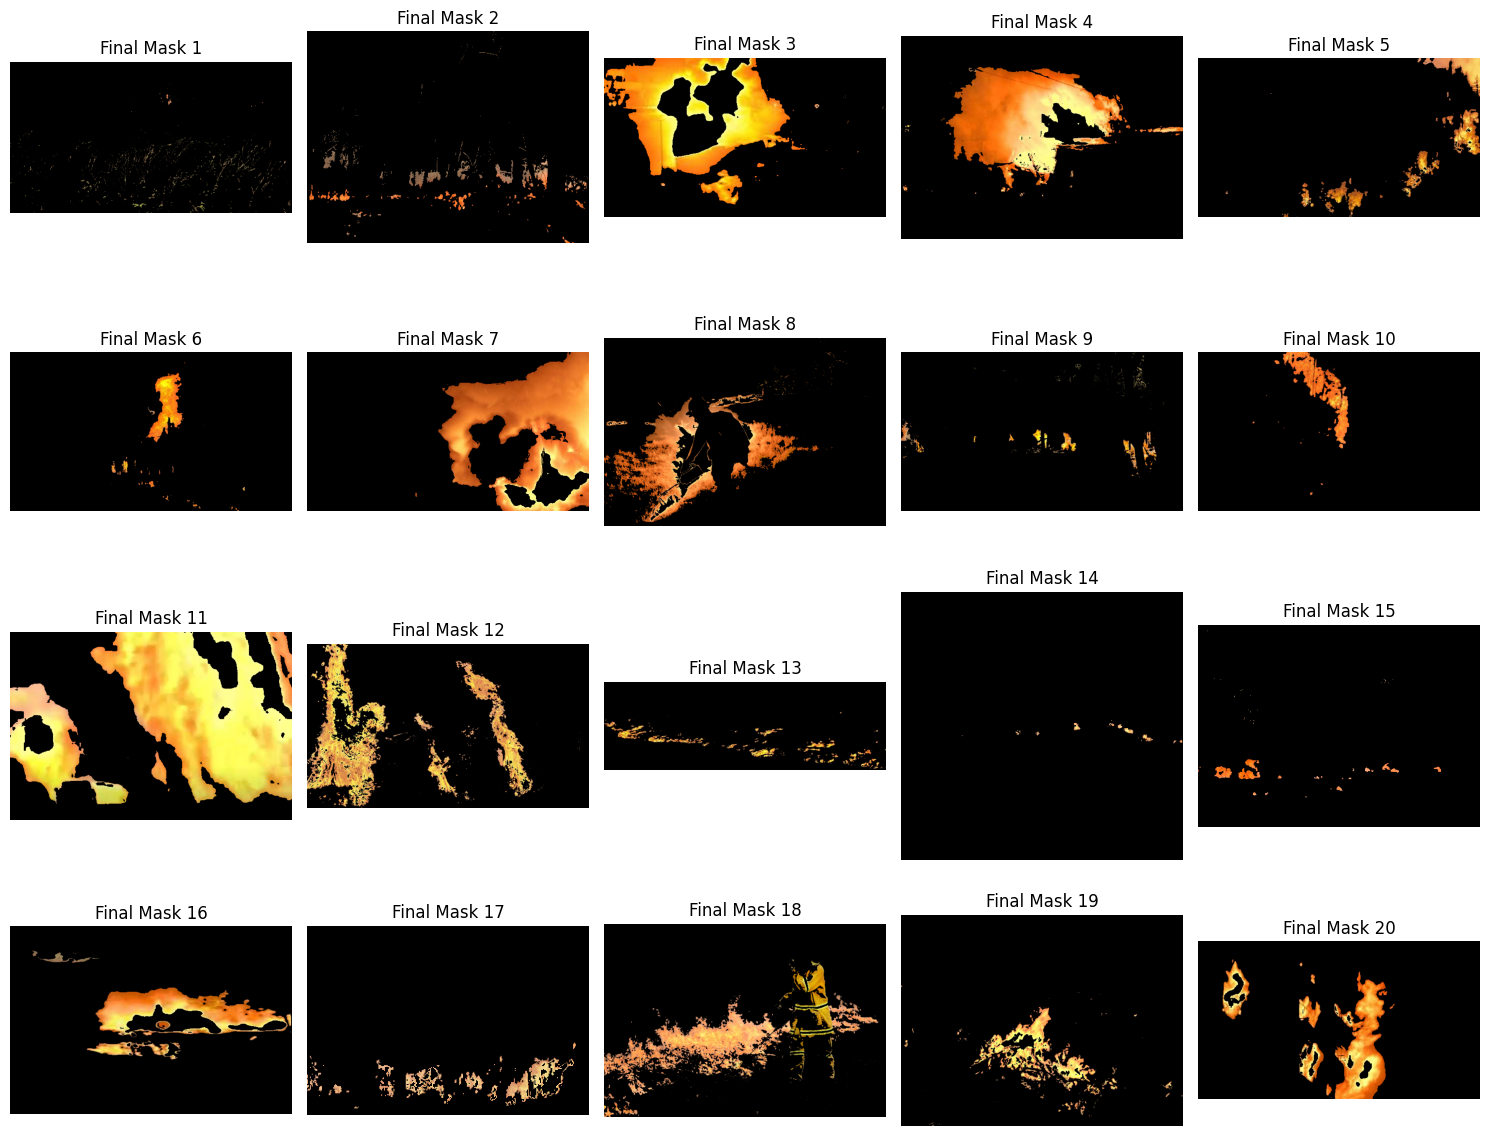

In [ ]:
# Applying the hsv mask and showing the result
final_fire = [apply_mask(masked_image, hsv_mask) for masked_image, hsv_mask in zip(fire_masked, fire_hsv_masks)]

show_images(final_fire[:20], [f"Final Mask {i+1}" for i in range(20)], 20, 5)

### Apply to non fire images

In [ ]:
nonfire_hsv_masks = [create_hsv_fire_mask(convert_to_hsv(nonfire_mask)) for nonfire_mask in nonfire_masked]
final_nonfire = [apply_mask(nonfire_mask, nonfire_hsv_mask) for nonfire_mask, nonfire_hsv_mask in zip(nonfire_masked, nonfire_hsv_masks)]

In [ ]:
show_images(final_nonfire[:20], [f"Final Mask {i+1}" for i in range(20)], 20, 5)

# Classification



## Modelling

In [ ]:
# Apply the feature extraction to both fire and non-fire images
fire_features = np.array([extract_combined_features(image, binary_mask, hsv_mask)
                          for image, binary_mask, hsv_mask in zip(final_fire, fire_binary_masks, fire_hsv_masks)])

non_fire_features = np.array([extract_combined_features(image, binary_mask, hsv_mask)
                              for image, binary_mask, hsv_mask in zip(final_nonfire, nonfire_masks, nonfire_hsv_masks)])

C:\Users\user\AppData\Local\Temp\ipykernel_20216\21462599.py:15: RuntimeWarning: invalid value encountered in scalar power
  skewness = np.nan_to_num(skewness_value ** (1/3)) if skewness_value != 0 else 0.0


In [ ]:
# Create labels, 1 for fire and 0 for non-fire
fire_labels = np.ones(len(fire_features))
non_fire_labels = np.zeros(len(non_fire_features))

In [ ]:
# Convert each list of features to a 2D array and combine them
fire_features = np.array(fire_features, dtype=np.float32)
non_fire_features = np.array(non_fire_features, dtype=np.float32)

# Concatenate features along the first axis to keep separate rows for each sample
X = np.vstack((fire_features, non_fire_features))

# Concatenate labels for both fire and non-fire samples
y = np.hstack((fire_labels, non_fire_labels))

In [ ]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
nan_count = np.isnan(X).sum()
print("Number of NaNs:", nan_count)

Number of NaNs: 0


In [ ]:
# Initialize and train the SVM classifier
svm_model = SVC(kernel='linear',
                probability=True)

svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=["Non-Fire", "Fire"]))

              precision    recall  f1-score   support

    Non-Fire       0.92      0.96      0.94        49
        Fire       0.99      0.97      0.98       151

    accuracy                           0.97       200
   macro avg       0.95      0.97      0.96       200
weighted avg       0.97      0.97      0.97       200



In [ ]:
# Assuming conf_matrix is generated as before
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0.0, 1.0])

# Extracting values from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

print("Confusion Matrix:")
print(conf_matrix)
print("\nBreakdown:")
print(f"True Negatives (Label 0 correctly predicted as 0): {TN}")
print(f"False Positives (Label 0 incorrectly predicted as 1): {FP}")
print(f"False Negatives (Label 1 incorrectly predicted as 0): {FN}")
print(f"True Positives (Label 1 correctly predicted as 1): {TP}")


Confusion Matrix:
[[ 47   2]
 [  4 147]]

Breakdown:
True Negatives (Label 0 correctly predicted as 0): 47
False Positives (Label 0 incorrectly predicted as 1): 2
False Negatives (Label 1 incorrectly predicted as 0): 4
True Positives (Label 1 correctly predicted as 1): 147


## Evaluation

In [ ]:
# Perform 5 folds cross validation
cv_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores):.2f}")

Cross-Validation Scores: [0.94       0.98       0.975      0.9798995  0.93467337]
Mean Cross-Validation Score: 0.96


In [ ]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=svm_model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Lo

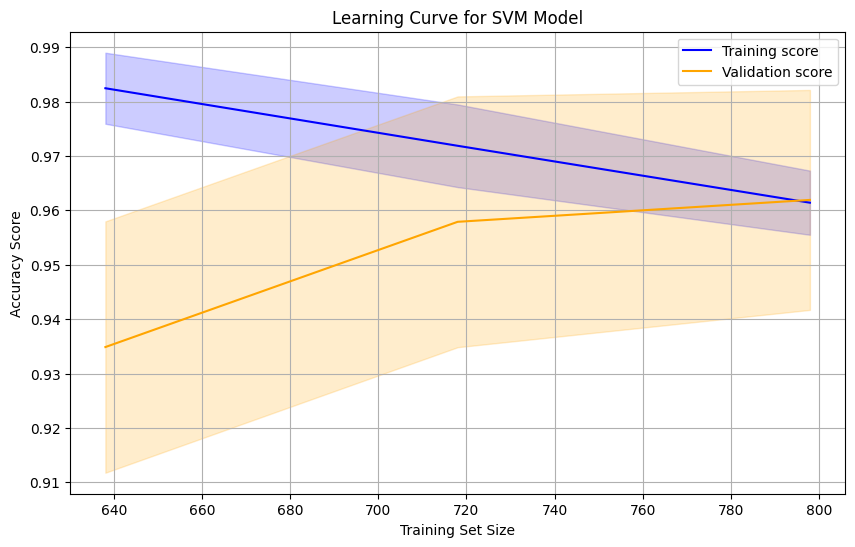

In [ ]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.plot(train_sizes, validation_scores_mean, label='Validation score', color='orange')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, color='orange', alpha=0.2)

plt.title("Learning Curve for SVM Model")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

# Testing

### Test Set Up

#### Colab

In [ ]:
fire_testp = '/content/drive/MyDrive/DATASET PCD/Testing/fire'
nofire_testp = '/content/drive/MyDrive/DATASET PCD/Testing/nofire'


firetest_files = os.listdir(fire_testp)
nofire_files = os.listdir(nofire_testp)

In [ ]:
# Load the images
fire_test = load_images(fire_testp, firetest_files)
nofire_test = load_images(nofire_testp, nofire_files)

#### Local

In [ ]:
# Path to your dataset folders
fire_testp = 'C:/Users/user/VSCode/DATA/UGM/PCD/Testing/fire'
nofire_testp = 'C:/Users/user/VSCode/DATA/UGM/PCD/Testing/nofire'

firetest_files = os.listdir(fire_testp)
nofire_files = os.listdir(nofire_testp)

In [ ]:
# Load the images
fire_test = load_images(fire_testp, firetest_files)
nofire_test = load_images(nofire_testp, nofire_files)

### Test Otsu

In [ ]:
# Creating the mask using advanced otsu and applying the mask  on the fire images
fire_test_masks = [advanced_otsu_thresholding(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) for image in fire_test]
fire_test_masked = [apply_mask(image, binary_mask) for image, binary_mask in zip(fire_test, fire_test_masks)]

# Applying to non_fire images
nofire_test_masks = [advanced_otsu_thresholding(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) for image in nofire_test]
nofire_test_masked = [apply_mask(image, nonfire_mask) for image, nonfire_mask in zip(nofire_test, nofire_test_masks)]


### Test HSV

In [ ]:
# Creating the mask using the hsv method using a pre defined boundary and applying the hsv mask
fire_test_hsv = [create_hsv_fire_mask(convert_to_hsv(masked_image)) for masked_image in fire_test_masked]
final_testfire = [apply_mask(masked_image, hsv_mask) for masked_image, hsv_mask in zip(fire_test_masked, fire_test_hsv)]

nofire_test_hsv = [create_hsv_fire_mask(convert_to_hsv(nonfire_mask)) for nonfire_mask in nofire_test_masked]
final_testnonfire = [apply_mask(nonfire_mask, hsv_mask) for nonfire_mask, hsv_mask in zip(nofire_test_masked, nofire_test_hsv)]

### Testing Model

In [ ]:
# Apply the feature extraction to both fire and non-fire images
testfire_features = np.array([extract_combined_features(image, binary_mask, hsv_mask)
                          for image, binary_mask, hsv_mask in zip(final_testfire, fire_test_masks, fire_test_hsv)])

testnofire_features = np.array([extract_combined_features(image, binary_mask, hsv_mask)
                              for image, binary_mask, hsv_mask in zip(final_testnonfire, nofire_test_masks, nofire_test_hsv)])

C:\Users\user\AppData\Local\Temp\ipykernel_20216\21462599.py:15: RuntimeWarning: invalid value encountered in scalar power
  skewness = np.nan_to_num(skewness_value ** (1/3)) if skewness_value != 0 else 0.0


In [ ]:
# Create labels, 1 for fire and 0 for non-fire
fire_labels = np.ones(len(testfire_features))
non_fire_labels = np.zeros(len(testnofire_features))

# Convert each list of features to a 2D array and combine them
testfire_features = np.array(testfire_features, dtype=np.float32)
testnofire_features = np.array(testnofire_features, dtype=np.float32)

# Concatenate features along the first axis to keep separate rows for each sample
X = np.vstack((testfire_features, testnofire_features))

# Concatenate labels for both fire and non-fire samples
y = np.hstack((fire_labels, non_fire_labels))

### Results

In [ ]:
# Make predictions on the test set
pred = svm_model.predict(X)

# Evaluate the model
print(classification_report(y, pred, target_names=["Non-Fire", "Fire"]))

              precision    recall  f1-score   support

    Non-Fire       0.96      0.83      0.89       190
        Fire       0.85      0.96      0.90       190

    accuracy                           0.90       380
   macro avg       0.90      0.90      0.90       380
weighted avg       0.90      0.90      0.90       380



In [ ]:
# Assuming conf_matrix is generated as before
conf_matrix = confusion_matrix(y_true=y, y_pred=pred, labels=[0.0, 1.0])

# Extracting values from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

print("Confusion Matrix:")
print(conf_matrix)

print("\nBreakdown:")
print(f"True Negatives (Label 0 correctly predicted as 0): {TN}")
print(f"False Positives (Label 0 incorrectly predicted as 1): {FP}")
print(f"False Negatives (Label 1 incorrectly predicted as 0): {FN}")
print(f"True Positives (Label 1 correctly predicted as 1): {TP}")

Confusion Matrix:
[[158  32]
 [  7 183]]

Breakdown:
True Negatives (Label 0 correctly predicted as 0): 158
False Positives (Label 0 incorrectly predicted as 1): 32
False Negatives (Label 1 incorrectly predicted as 0): 7
True Positives (Label 1 correctly predicted as 1): 183


# Checking Mask

In [ ]:
show_images(final_fire, [f"Final Mask {i+1}" for i in range(717)], 717, 5)